# AnaLyrics Engine: Predicting Music Genres with NLP

## Business Undersatanding
This project leverages song lyrics and metadata to classify songs into distinct music genres. Genre classification is not an exact science, and given the vast diversity of music today, there are innumerable categories a song could belong to.

As a passionate music lover and avid concert goer, I tend to have a curated playlist for every possible mood and occassion. This is a tedious task to do manually, and I have often thought how nice it would be to be able to input my current mood and desired music style (ex: sad bangers) and have a playlist made personally for me.

Spotify has attempted to do this with their [daylist](https://newsroom.spotify.com/2023-09-12/ever-changing-playlist-daylist-music-for-all-day/)- a personalized playlist that "ebbs and flows with unique vibes, bringing together the niche music and microgenres you usually listen to during particular moments in the day or on specific days of the week."

The daylist updates organically throughout the day and is based on your past listening habits. This project attempts to build on that concept by curating a playlist based on a user's desired vibe. In order to get to an end goal of song recommendations based on lyrics and audio features, the first step was to build a supervised model trained to predict a song's genre based purely on the words it contains.

## Data Understanding
The first step in building the dataset was identifying the prediction target- music genres. [Every Noise At Once](https://everynoise.com/engenremap.html) is “an ongoing attempt at an algorithmically-generated, readability-adjusted scatter-plot of the musical genre-space." The project was created in 2013 by Glenn McDonald, a former Spotify developer, based on data tracked and analyzed for ~6000 Spotify genres. (last updated November 2023)

The songs for each genre were collected from the playlists provided by the Every Noise project, and all of the song metadata and audio features were gathered using [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/), a Python wrapper for the [Spotify API](https://developer.spotify.com/documentation/web-api). Next, lyrics for each song were scraped from [Genius](https://genius.com) using [LyricsGenius](https://lyricsgenius.readthedocs.io/en/master/reference/genius.html).

# Data Preparation
To prepare the data for modeling, we performed preprocessing steps such as text cleaning, tokenization, and vectorization of lyrics. The text cleaning process before model preprocessing is outined in the [data cleaning](code/data_cleaning) notebook.

After combining all the data and dropping bad records, we were left with 2024 songs.

**Modeling**

We then trained various models including Naive Bayes and Random Forests on the labeled dataset. Using grid search and cross-validation techniques we tuned the paramaters to minimize observed overfitting.







# Modeling

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("dark")

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


In [90]:
df = pd.read_csv('data/lyrics2.csv')
df['genre'].value_counts(normalize=True)*100

rock       31.126482
pop        25.444664
country    24.407115
hip hop    19.021739
Name: genre, dtype: float64

In [85]:
def preprocess_text(lyrics):
    # remove numbers and special characters
    lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    # remove extra spaces and new lines
    lyrics = re.sub(r'\s+|\n\s*\n', ' ', lyrics)
    # lowercase all
    lyrics = lyrics.lower()
    # tokenize, lemmatize, remove stopwords
    tokens = word_tokenize(lyrics)
    lemmer = WordNetLemmatizer()
    tokens = [lemmer.lemmatize(word) for word in tokens]
    sw = stopwords.words('english')
    tokens = ' '.join([word for word in tokens if word not in sw])
    return tokens

In [86]:
df['tokens'] = df['lyrics_text'].apply(preprocess_text)
df['tokens']

0       puttin defense cause dont wan na fall love eve...
1       thats love thats love dont need time make mind...
2       wake morning feelin like p diddy hey girl grab...
3       good gold kinda dream cant sold right til were...
4       found heart wa broke filled cup overflowed too...
                              ...                        
2019    saturday night six pack girl big star shining ...
2020    oclock friday night im still home girl keep bl...
2021    hard find perfect time say something know gon ...
2022    tried get sober didnt get far im gon na pour c...
2023    little outside elizabethtown little bar id sit...
Name: tokens, Length: 2024, dtype: object

In [157]:
def analyze_model(model, X, y):
    
    # k-fold validation 
    kfold = KFold(n_splits=5, shuffle=True, random_state=95)
    nb_kfold_scores = cross_validate(model, X, y, cv=kfold, scoring='accuracy', return_train_score=True)
    print('Cross-Validation Results:')
    for fold, (train_score, test_score) in enumerate(zip(nb_kfold_scores['train_score'], nb_kfold_scores['test_score'])):
        print(f"Fold {fold + 1}: Train = {train_score:.3f}, Test = {test_score:.3f}")
    print()
    print(f"Avg Train Accuracy: {nb_kfold_scores['train_score'].mean():.3f}")
    print(f"Avg Test Accuracy: {nb_kfold_scores['test_score'].mean():.3f}")
    print()

    # train test split for predictions
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=95)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    genre_labels = np.unique(y_te)

    genres = ['pop', 'rock', 'hip hop', 'country']
    print("Classification Report:")
    print(classification_report(y_te, pred))

    cm = confusion_matrix(y_te, pred, normalize='true')
    sns.heatmap(cm, xticklabels=genre_labels, yticklabels=genre_labels,
                annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [22]:
# set variables for modeling
X = df['tokens']
y = df['genre']

# split holdout set for final model validation
X_df, X_hold, y_df, y_hold = train_test_split(X, y, test_size=0.2, random_state=95)

rock       30.574429
pop        26.065473
country    24.336010
hip hop    19.024089
Name: genre, dtype: float64

## Baseline

In [77]:
X_tr, X_te, y_tr, y_te = train_test_split(X_df, y_df, test_size=0.2, random_state=95)

# use dummy classifier as baseline model
baseline = DummyClassifier(strategy='uniform')
baseline.fit(X_tr, y_tr)
base_pred = baseline.predict(X_te)
base_score = accuracy_score(y_te, base_pred)
print(f'Baseline Accuracy: {base_score:.2f}')

Baseline Accuracy: 0.31


## Naive Bayes

Cross-Validation Results:
Fold 1: Train = 0.858, Test = 0.602
Fold 2: Train = 0.870, Test = 0.617
Fold 3: Train = 0.876, Test = 0.568
Fold 4: Train = 0.886, Test = 0.528
Fold 5: Train = 0.891, Test = 0.644

Avg Train Accuracy: 0.876
Avg Test Accuracy: 0.592

Classification Report:
              precision    recall  f1-score   support

     country       0.79      0.57      0.66        84
     hip hop       0.87      0.48      0.62        56
         pop       0.61      0.47      0.53        95
        rock       0.47      0.84      0.61        89

    accuracy                           0.60       324
   macro avg       0.69      0.59      0.61       324
weighted avg       0.66      0.60      0.60       324



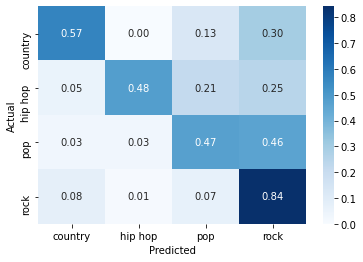

In [158]:
# basic naive bayes model 

nb_pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
]) 

analyze_model(nb_pipe, X_df, y_df)

In [114]:
# grid search for best parameters to address overfitting

nb_params = {
    'vect': [CountVectorizer(), TfidfVectorizer()],
    'vect__max_features': [None, 200, 500],
    'vect__min_df': [5, 10, 25],
    'vect__max_df': [0.5, 0.75, 1.0],

    'clf__alpha': [0.1, 0.5, 1.0],
}

nb_grid = GridSearchCV(nb_pipe, nb_params, cv=5, scoring='accuracy')
nb_grid.fit(X_df, y_df)
nb_grid.best_params_

Naive Bayes Best Params:  {'clf__alpha': 1.0, 'vect': CountVectorizer(), 'vect__max_df': 0.75, 'vect__max_features': None, 'vect__min_df': 10}


Cross-Validation Results:
Fold 1: Train = 0.812, Test = 0.627
Fold 2: Train = 0.812, Test = 0.657
Fold 3: Train = 0.815, Test = 0.602
Fold 4: Train = 0.819, Test = 0.620
Fold 5: Train = 0.804, Test = 0.625

Avg Train Accuracy: 0.812
Avg Test Accuracy: 0.626

Classification Report:
              precision    recall  f1-score   support

     country       0.67      0.62      0.64        84
     hip hop       0.70      0.88      0.78        56
         pop       0.60      0.53      0.56        95
        rock       0.57      0.58      0.57        89

    accuracy                           0.63       324
   macro avg       0.63      0.65      0.64       324
weighted avg       0.62      0.63      0.62       324



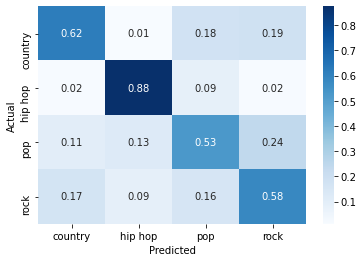

In [159]:
# tuned naive bayes

nb_tuned = Pipeline([
    ('vect', CountVectorizer(min_df=20, max_df=.75)),
    ('clf', MultinomialNB(alpha=0.1))
])

analyze_model(nb_tuned, X_df, y_df)

## Random Forest

Cross-Validation Results:
Fold 1: Train = 0.987, Test = 0.630
Fold 2: Train = 0.985, Test = 0.651
Fold 3: Train = 0.986, Test = 0.620
Fold 4: Train = 0.990, Test = 0.639
Fold 5: Train = 0.984, Test = 0.690

Avg Train Accuracy: 0.986
Avg Test Accuracy: 0.646

Classification Report:
              precision    recall  f1-score   support

     country       0.83      0.51      0.63        84
     hip hop       0.83      0.88      0.85        56
         pop       0.67      0.43      0.53        95
        rock       0.52      0.89      0.66        89

    accuracy                           0.65       324
   macro avg       0.71      0.68      0.67       324
weighted avg       0.70      0.65      0.65       324



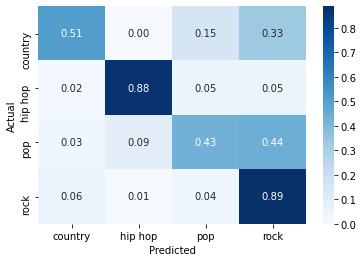

In [162]:
# simple random forest

rf_pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

analyze_model(rf_pipe, X_df, y_df)

In [175]:
# grid search for best parameters to address overfitting

rf_params = {
    # 'vect': [CountVectorizer(), TfidfVectorizer()],
    # 'vect__max_features': [None, 1000, 2000],
    # 'vect__min_df': [2, 10, 25,50],
    # 'vect__max_df': [0.5, 0.75, 1.0],

    'clf__n_estimators': [500, 600, 800],
    'clf__max_depth': [20, 30, 50],
    'clf__min_samples_split': [4, 6, 12],
    'clf__min_samples_leaf': [2, 4, 7]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_df, y_df)
rf_grid.best_params_


{'clf__max_depth': 50,
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 12,
 'clf__n_estimators': 800}

Cross-Validation Results:
Fold 1: Train = 0.963, Test = 0.679
Fold 2: Train = 0.960, Test = 0.679
Fold 3: Train = 0.964, Test = 0.642
Fold 4: Train = 0.970, Test = 0.673
Fold 5: Train = 0.965, Test = 0.681

Avg Train Accuracy: 0.964
Avg Test Accuracy: 0.671

Classification Report:
              precision    recall  f1-score   support

     country       0.80      0.48      0.60        84
     hip hop       0.85      0.91      0.88        56
         pop       0.75      0.51      0.60        95
        rock       0.53      0.89      0.66        89

    accuracy                           0.67       324
   macro avg       0.73      0.69      0.69       324
weighted avg       0.72      0.67      0.67       324



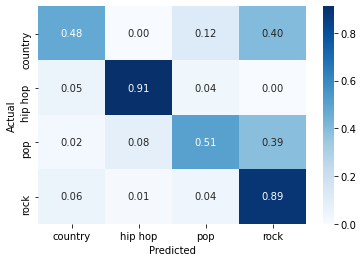

In [174]:
# tuned random forest

rf_tuned = Pipeline([
    ('vect', CountVectorizer(min_df= 20, 
                             max_df= .75)),
    ('clf', RandomForestClassifier(n_estimators=500,
                                   max_depth=70,
                                   min_samples_split= 3,
                                   min_samples_leaf= 3))
])

analyze_model(rf_tuned, X_df, y_df)